In [88]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.constants as c
from scipy import stats

from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy import units as u
from regions import Regions

import os
import sys
from astropy.table import Table, join, vstack
from astropy.nddata.utils import extract_array
import pyregion
import tqdm 
import argparse

import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=AstropyWarning, append=True)

import integratedflux_py3 as flux_py3
from importlib import reload
reload(flux_py3)

<module 'integratedflux_py3' from '/net/vdesk/data2/GoesaertW/Data_Analyis_Git/integratedflux_py3.py'>

In [3]:
path_rmsynth = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/rmsynth/'
fname_linpol = 'rmsynth_polint'
hdu_polint = fits.open(get_pkg_data_filename(path_rmsynth+fname_linpol+'.fits'))[0]
data_polint = hdu_polint.data

path_sigma = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'
fname_sigma = 'Abell_85_Fits_Data_Mean_Std'
hdu_sigma = fits.open(get_pkg_data_filename(path_sigma+fname_sigma+'.fits'))[0]
data_sigma = hdu_sigma.data

hdu_phi = fits.open(get_pkg_data_filename(path_rmsynth+'rmsynth_phi.fits'))[0]
data_phi = hdu_phi.data
header_phi = hdu_phi.header
del header_phi['CROTA4']
wcs = WCS(header_phi)

path_git = r'/net/vdesk/data2/GoesaertW/Data_Analyis_Git/'
rsl = fits.open(get_pkg_data_filename(path_git+'Abell85_catalog_BDSF_rsl.fits'))[1].data
region_name = "Abell85_catalog_BDSF_rsl.reg"
reg_file = Regions.read(region_name)

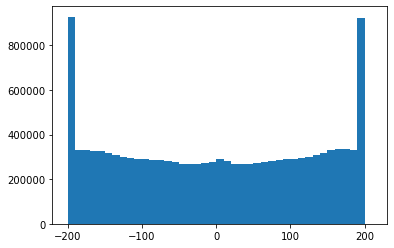

In [4]:
plt.hist(data_phi.flatten(), bins=np.linspace(-200, 210, 42))
plt.show()

In [5]:
sources_worldpos = np.array((rsl['RA'], rsl['DEC']))
sources_pixpos_floats = wcs.all_world2pix(rsl['RA'], rsl['DEC'], 0)
sources_pixpos = np.swapaxes(np.rint(sources_pixpos_floats\
                                     , out=np.zeros(np.shape(sources_worldpos)
                                     , int), casting='unsafe'),0,1)

sources_phi = data_phi[sources_pixpos[:,1], sources_pixpos[:,0]]
sources_polint = data_polint[sources_pixpos[:,1], sources_pixpos[:,0]]
sources_sigma = data_sigma[sources_pixpos[:,1], sources_pixpos[:,0]]

polarized_mask = (sources_sigma>4)

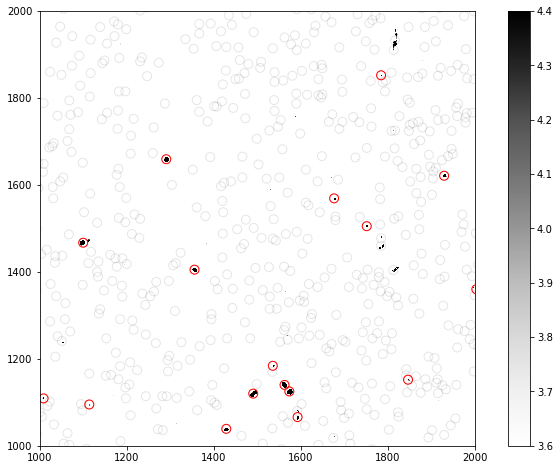

<ipython-input-80-6ab7ad08f5aa>:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(a)


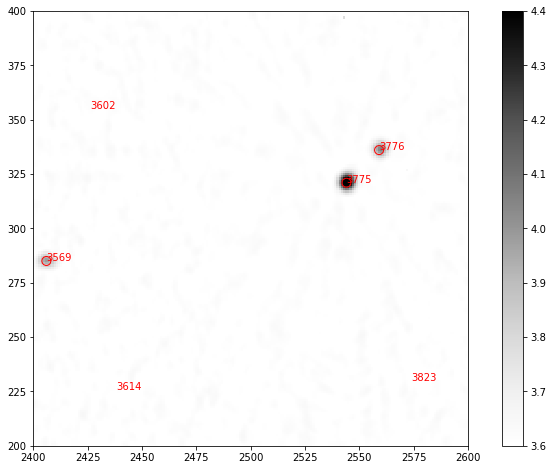

In [80]:
plt.figure(figsize=(12,8))
a = plt.imshow(data_sigma, cmap='Greys', vmin=4, vmax=4, origin='lower', interpolation='nearest')
plt.scatter(sources_pixpos[:,0], sources_pixpos[:,1], s=80, facecolors='none', edgecolors='black', alpha=0.1)
plt.scatter(sources_pixpos[polarized_mask,0], sources_pixpos[polarized_mask,1], s=80, facecolors='none', edgecolors='r')
plt.colorbar(a)
plt.xlim(1000,2000)
plt.ylim(1000,2000)
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(data_sigma, cmap='Greys', origin='lower', vmin=0, vmax=60, interpolation='nearest')
#plt.scatter(sources_pixpos[:,0], sources_pixpos[:,1], s=80, facecolors='none', edgecolors='black', alpha=0.1)
plt.scatter(sources_pixpos[polarized_mask,0], sources_pixpos[polarized_mask,1], s=80, facecolors='none', edgecolors='r')
for n in range(len(sources_pixpos[:,0])):
    plt.text(sources_pixpos[:,0][n], sources_pixpos[:,1][n], str(n), color='red', clip_on=True)
plt.colorbar(a)
plt.xlim(2400,2600)
plt.ylim(200,400)
plt.show()

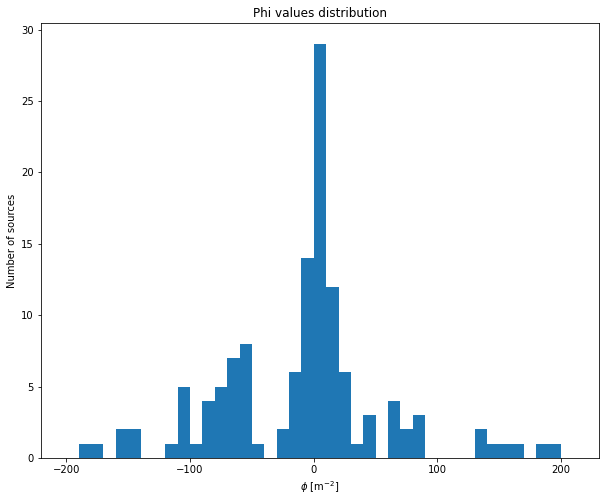

In [7]:
plt.figure(figsize=(10,8))
plt.hist(sources_phi[polarized_mask], bins=np.linspace(-200, 210, 42))
plt.title('Phi values distribution')
plt.ylabel('Number of sources')
plt.xlabel('$\phi$ [m$^{-2}$]')
plt.show()

In [121]:
polstrength = np.zeros(len(sources_phi))
n_beams = np.zeros(len(sources_phi))
for n in tqdm.tqdm(range(len(polstrength))):
    polstrength[n], n_beams[n] = flux_py3.integratedflux(path_sigma+fname_sigma+'.fits', reg_file, n, hdul=hdu_phi, test=False, linpolselect=True)

100%|██████████| 4946/4946 [00:46<00:00, 105.62it/s]


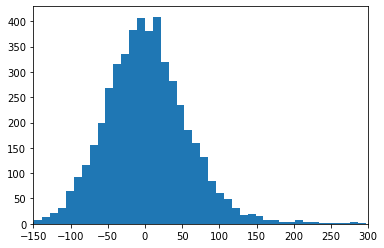

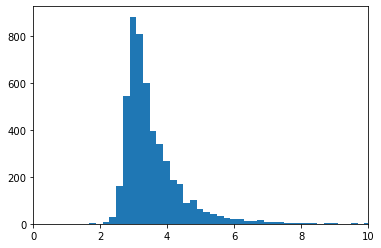

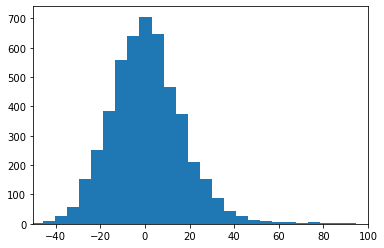

In [127]:
plt.hist(polstrength, bins=1000)
plt.xlim(-150,300)
plt.show()

plt.hist(n_beams, bins=100)
plt.xlim(0,10)
plt.show()

plt.hist(polstrength/n_beams, bins=300)
plt.xlim(-50,100)
plt.show()

125
132


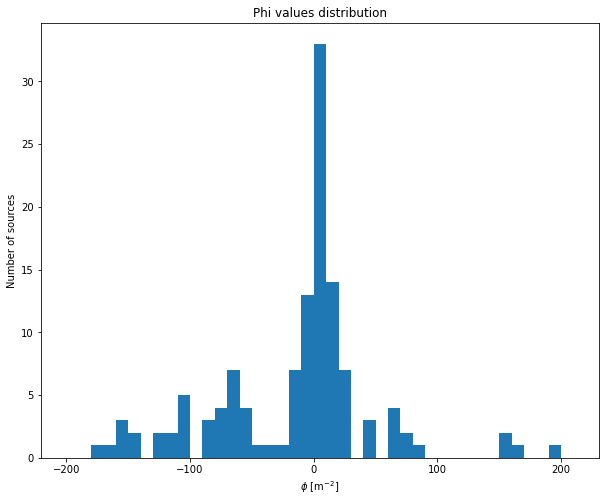

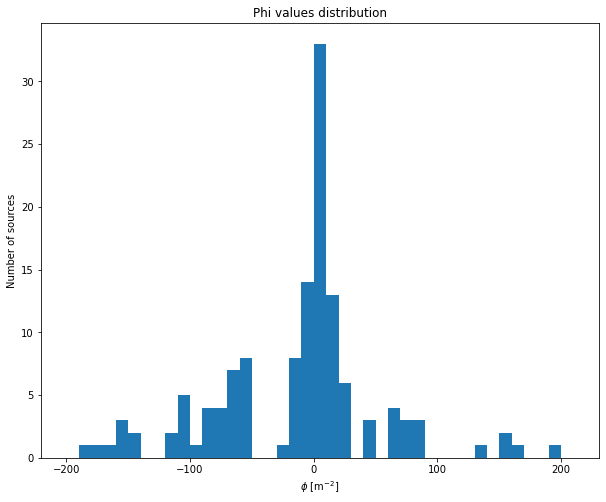

In [130]:
polarized_mask_2 = (polstrength>200)
polarized_mask_3 = (polstrength/n_beams>50)
print(len(polstrength[polarized_mask_2]))
print(len(polstrength[polarized_mask_3]))

plt.figure(figsize=(10,8))
plt.hist(sources_phi[polarized_mask_2], bins=np.linspace(-200, 210, 42))
plt.title('Phi values distribution')
plt.ylabel('Number of sources')
plt.xlabel('$\phi$ [m$^{-2}$]')
plt.show()

plt.figure(figsize=(10,8))
plt.hist(sources_phi[polarized_mask_3], bins=np.linspace(-200, 210, 42))
plt.title('Phi values distribution')
plt.ylabel('Number of sources')
plt.xlabel('$\phi$ [m$^{-2}$]')
plt.show()

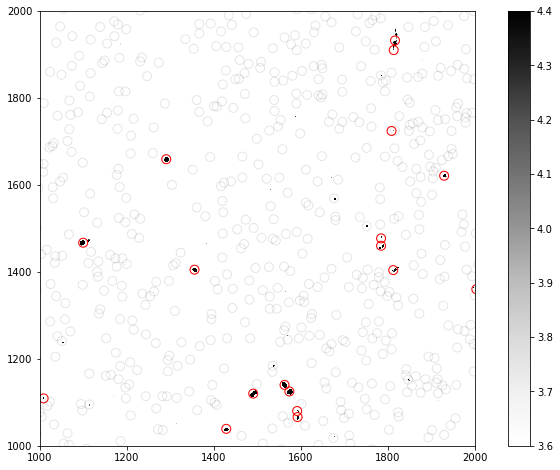

<ipython-input-118-e59a7a2ec140>:14: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(a)


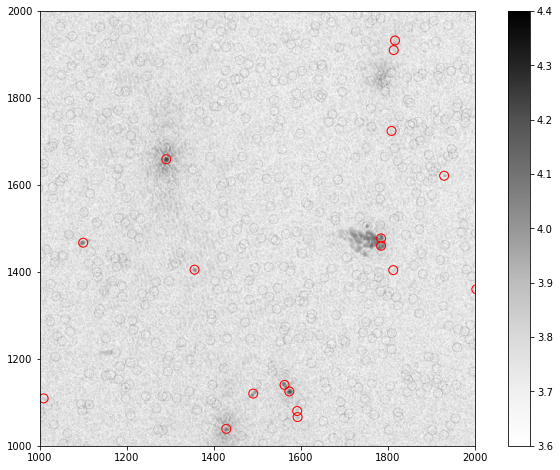

In [118]:
plt.figure(figsize=(12,8))
a = plt.imshow(data_sigma, cmap='Greys', vmin=4, vmax=4, origin='lower', interpolation='nearest')
plt.scatter(sources_pixpos[:,0], sources_pixpos[:,1], s=80, facecolors='none', edgecolors='black', alpha=0.1)
plt.scatter(sources_pixpos[polarized_mask_2,0], sources_pixpos[polarized_mask_2,1], s=80, facecolors='none', edgecolors='r')
plt.colorbar(a)
plt.xlim(1000,2000)
plt.ylim(1000,2000)
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(data_polint.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.scatter(sources_pixpos[:,0], sources_pixpos[:,1], s=80, facecolors='none', edgecolors='black', alpha=0.1)
plt.scatter(sources_pixpos[polarized_mask_2,0], sources_pixpos[polarized_mask_2,1], s=80, facecolors='none', edgecolors='r')
plt.colorbar(a)
plt.xlim(1000,2000)
plt.ylim(1000,2000)
plt.show()

In [119]:
savedir =r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/Photometry_BDSF/'

flux_measurements_I = np.load(savedir+'Abell85_BDSF_I.npy')
flux_measurements_Q = np.load(savedir+'Abell85_BDSF_Q.npy')
flux_measurements_U = np.load(savedir+'Abell85_BDSF_U.npy')
flux_unc_I = np.load(savedir+'Abell85_BDSF_unc_I.npy')
flux_unc_Q = np.load(savedir+'Abell85_BDSF_unc_Q.npy')
flux_unc_U = np.load(savedir+'Abell85_BDSF_unc_U.npy')

Linpol = np.sqrt(flux_measurements_Q**2 + flux_measurements_U**2)
Pol_Angles = 0.5*np.arctan(flux_measurements_U/flux_measurements_Q)

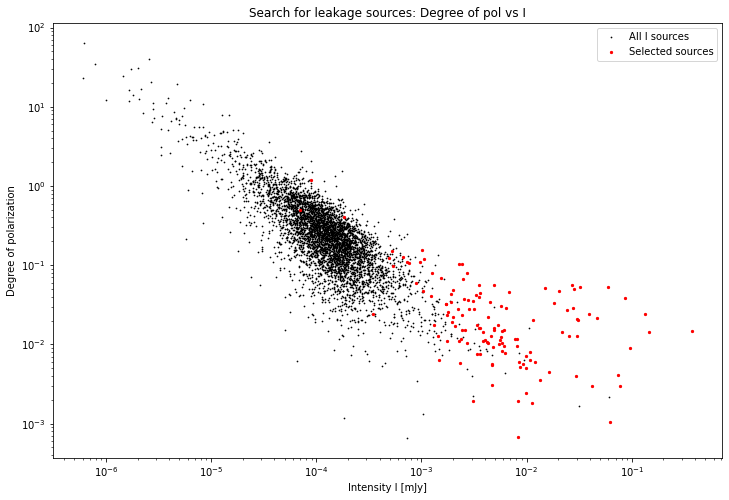

In [131]:
plt.figure(figsize=(12,8))
plt.title('Search for leakage sources: Degree of pol vs I')
for n in range(1):
    plt.scatter(flux_measurements_I[n], Linpol[n]/flux_measurements_I[n], color='black', label='All I sources', s=0.5)
for n in range(1):
    plt.scatter(flux_measurements_I[n][polarized_mask_3], Linpol[n][polarized_mask_3]/flux_measurements_I[n][polarized_mask_3], color='red', label='Selected sources', s=5)
plt.xlabel('Intensity I [mJy]')
plt.ylabel('Degree of polarization')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-6, 1e-3)
#plt.ylim(1e-2, 1e2)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Search for leakage sources: Degree of pol vs I')
for n in range(1):
    plt.scatter(flux_measurements_I[n], Linpol[n]/flux_measurements_I[n], color=((11-n)/12,0,n/12), label='Freq band '+str(n+1), s=0.5)
plt.xlabel('Intensity I [mJy]')
plt.ylabel('Degree of polarization')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-6, 1e-3)
#plt.ylim(1e-2, 1e2)
plt.legend()
plt.show()